In [ ]:
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.metrics import R2Score
from keras.models import load_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Testing model and graphing predictions

In [ ]:
train = pd.read_csv('normalized_training_data.csv')
test = pd.read_csv('normalized_testing_data.csv')

In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
class customLSTM():
    def __init__(self, path = '', prediction_metric = 'Price', n_features = 1, n_steps = 50):
        if not path:
            self.n_steps = n_steps
            self.prediction_metric = prediction_metric
            self.trained = 0
            self.tested = 0
            self.model = Sequential()
            self.model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
            self.model.add(Dense(1))
            self.model.compile(optimizer='sgd', loss='mse', metrics=[R2Score()])
            print(self.model.summary())
        else:
            self.model = load_model(path)
            vars = path.split('/')[-1].split('-')
            self.prediction_metric = vars[0]
            self.n_steps = int(vars[1])
            self.epochs = int(vars[2][:-1])
            self.accuracy = float(int(vars[3][2:].split('.')[0]) / 10000)
            self.trained = 1
            self.tested = 1
            print(self.model.summary())

    def sequence_df(self, df):
        ins = []
        out = []
        for col in df.columns:
            if col == self.prediction_metric:
                out = array(df[col][:-1])
                out = np.insert(out, 0, 0)
                out = out.reshape((len(out), 1))
            elif col != 'Date':
                c = array(df[col])
                c = c.reshape((len(c), 1))
                ins.append(c)

        ins.append(out)
        data = hstack(tuple(ins))
        X, y = split_sequences(data, self.n_steps)
        return X, y

    def train(self, df, epochs = 50, verbose = 1):
        self.trained = 1
        self.tested = 0
        self.epochs = epochs
        self.trainingset = df
        self.Xtrain, self.Ytrain = self.sequence_df(df)
        self.model.fit(self.Xtrain, self.Ytrain, epochs = epochs, verbose = verbose)

    def test(self, df, verbose = 1):
        self.tested = 1
        self.testingset = df
        self.Xtest, self.Yactual = self.sequence_df(df)
        self.Yactual = self.Yactual.reshape((len(self.Yactual), 1))
        self.Ypredicted = self.model.predict(self.Xtest, verbose=verbose)
        metric = R2Score()
        metric.update_state(self.Yactual, self.Ypredicted)
        self.accuracy = metric.result()
        print(f'R2 Score: {metric.result()}')

    def save(self):
        if not self.trained or not self.tested:
            print('Model must be trained and tested before it can be saved.')
            return
        name = f'{self.prediction_metric}-{self.n_steps}-{self.epochs}E-0_{int(self.accuracy * 10000)}.keras'
        print(f'Model saved as {name}')
        self.model.save(name)

    def plotResults(self):
        plt.figure(figsize=(14, 7))
        plt.plot(self.Yactual, label='Actual')
        plt.plot(self.Ypredicted, label='Predicted')

        dates = list(self.testingset['Date'][self.n_steps+1:])
        plt.xticks(range(0, len(dates), 20), dates[::20], rotation=70)

        plt.title('Predicted vs Actual Values')
        plt.xlabel('Date')
        plt.legend()
        plt.show()

In [ ]:
model = customLSTM(prediction_metric='Price', n_features=len(train.columns) - 2, n_steps=50)
model.train(train, epochs=100, verbose=1)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 50)                12200     
                                                                 
 dense_17 (Dense)            (None, 1)                 51        
                                                                 
Total params: 12251 (47.86 KB)
Trainable params: 12251 (47.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
50/50 [==============================] - 3s 19ms/step - loss: 0.0968 - r2_score: -0.7132
Epoch 2/10
50/50 [==============================] - 1s 19ms/step - loss: 0.0103 - r2_score: 0.8185
Epoch 3/10
50/50 [==============================] - 1s 20ms/step - loss: 0.0055 - r2_score: 0.9035
Epoch 4/10
50/50 [==============================] - 1s 20ms/step - loss: 0.0030 - r2_score: 0.9461
Epoch 5/10


R2 Score: 0.8403365612030029


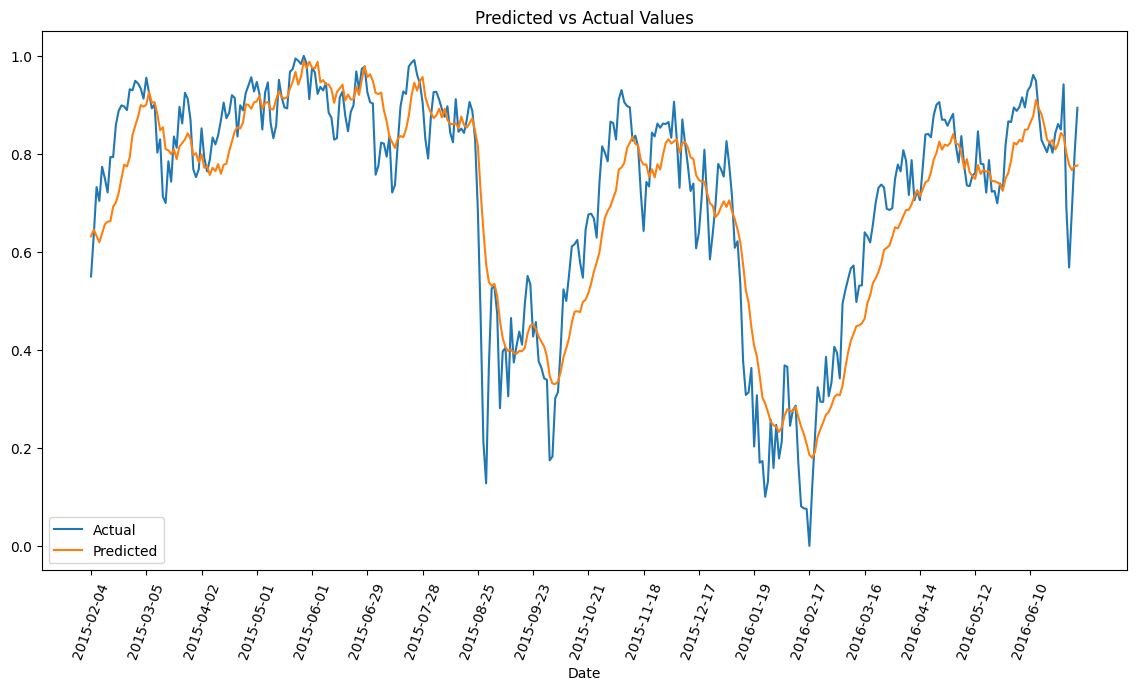

In [ ]:
model.test(test, verbose=0)
model.plotResults()

In [ ]:
model.save()

In [ ]:
loadmodel = customLSTM(path='Price-50-100E-0_8828.keras')

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 50)                12200     
                                                                 
 dense_14 (Dense)            (None, 1)                 51        
                                                                 
Total params: 12251 (47.86 KB)
Trainable params: 12251 (47.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


R2 Score: 0.8822789192199707


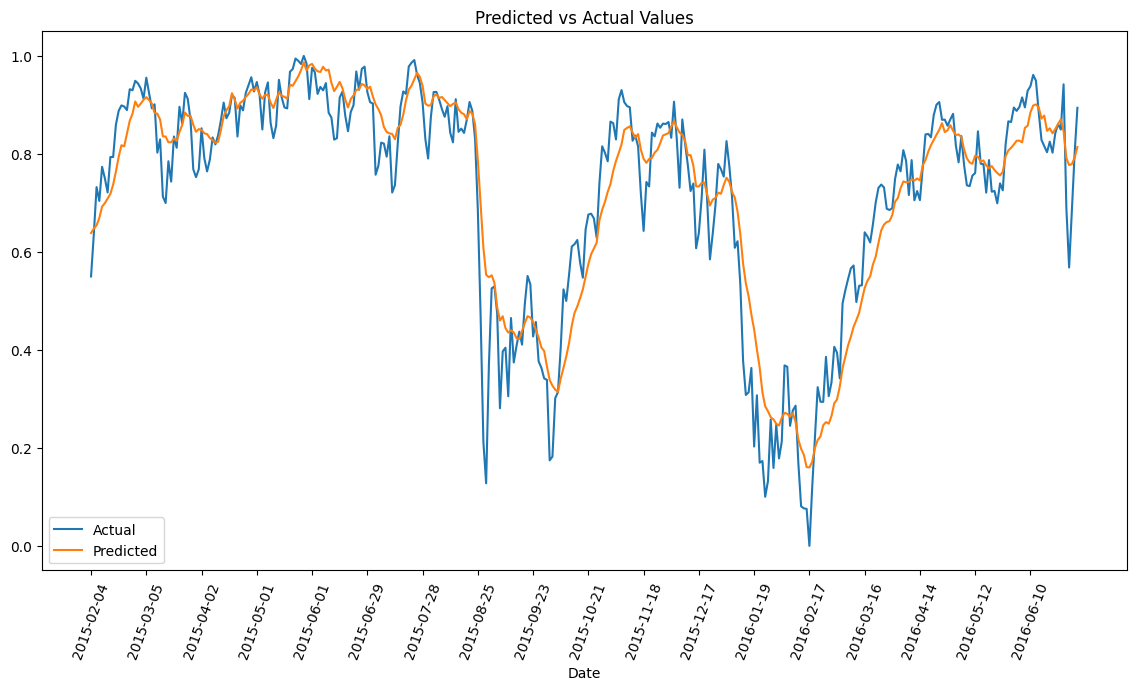

In [ ]:
loadmodel.test(test, verbose=0)
loadmodel.plotResults()